## **Import**


*   구글 드라이브와 연결!
*   필요한 import 가지고 오기! (자바 import java.util.Scanner와 비슷한 것!)





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings(action='ignore')

## **Fixed Random-Seed**


*   이는 값이 계속해서 바뀌는 것을 방지!
*   일관성 있는 결과가 나오기 위해 설정!



In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## **Load Data**


*   대회에 사용될 데이터 불러오기!
*   각각 파일이 저장되어 있는 경로를 불러와야한다! (구글 드라이브에 파일 다 넣어야 함)
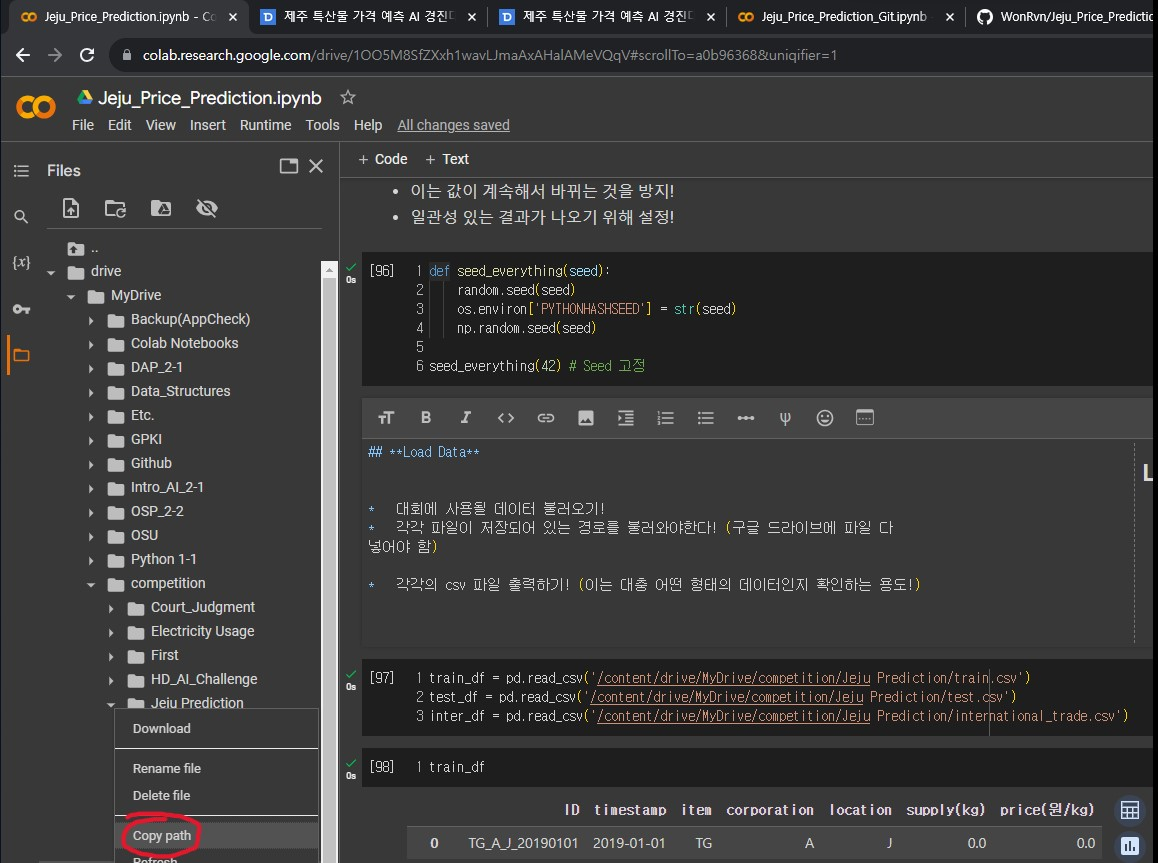

*   각각의 csv 파일 출력하기! (이는 대충 어떤 형태의 데이터인지 확인하는 용도!)



In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/001-메이저러너/제주특산물 가격예측/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/001-메이저러너/제주특산물 가격예측/test.csv')
inter_df = pd.read_csv('/content/drive/MyDrive/001-메이저러너/제주특산물 가격예측/international_trade.csv')

In [ ]:
train_df

In [ ]:
inter_df

In [ ]:
test_df

## **Checking Data**

Train Data

In [ ]:
count_items = train_df['item'].value_counts()
print(count_items)

In [ ]:
count_items_corporation = train_df['corporation'].value_counts()
print(count_items_corporation)

International Data

In [ ]:
count_items_inter = inter_df['품목명'].value_counts()
print(count_items_inter)

In [ ]:
# Grouping the data by '품목명' and calculating the sum for each numeric attribute
grouped_inter_df = inter_df.groupby('품목명').agg({
    '수출 중량': 'sum',
    '수출 금액': 'sum',
    '수입 중량': 'sum',
    '수입 금액': 'sum',
    '무역수지': 'sum'
}).reset_index()

grouped_inter_df.head()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Extracting the numeric attributes for the cosine similarity calculation
numeric_data = grouped_inter_df.drop('품목명', axis=1)

# Calculating the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(numeric_data)

# Converting the cosine similarity matrix to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=grouped_inter_df['품목명'], columns=grouped_inter_df['품목명'])

cosine_sim_df.head()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Performing hierarchical clustering
hclust = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='complete')
clusters = hclust.fit_predict(1 - cosine_sim_df)  # Using 1 - similarity as distance

# Assigning the cluster labels to the original DataFrame
grouped_inter_df['Cluster'] = clusters

# Viewing the items grouped by cluster
clustered_items = grouped_inter_df[['품목명', 'Cluster']].sort_values(by='Cluster')
clustered_items.groupby('Cluster').agg({'품목명': lambda x: list(x)})

## **Heatmap Visualization**


*   열들 간의 상관관계 파악!


In [ ]:
# Calculate the correlation matrix
corr_matrix = train_df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Heatmap of Feature Correlations')
plt.show()

## **Box Plot Visualization**


*   Outlier(이상치) 여부 파악을 위해 시각화 하였음! (이상치가 있으면 학습하는데 이상한 결과가 나올 가능성이 있음)




In [ ]:
# Plotting boxplots to visualize outliers
plt.figure(figsize=(15, 5))

# Boxplot for supply(kg)
plt.subplot(1, 2, 1)
sns.boxplot(x=train_df['supply(kg)'])
plt.title('Boxplot for supply(kg)')

# Boxplot for price(원/kg)
plt.subplot(1, 2, 2)
sns.boxplot(x=train_df['price(원/kg)'])
plt.title('Boxplot for price(원/kg)')

plt.show()

## **Checking Outliers Using Z-Score**

*   Z-Score 이용하여 추가적으로 파악! (시각화만으로 이상치 제거하기엔 힘듦)



In [ ]:
from scipy import stats

# Calculate the Z-scores of `supply(kg)` and `price(원/kg)`
train_df['supply_z'] = np.abs(stats.zscore(train_df['supply(kg)']))
train_df['price_z'] = np.abs(stats.zscore(train_df['price(원/kg)']))

# Define a threshold for identifying an outlier
threshold = 3

# Identify outliers
outliers_supply = train_df[train_df['supply_z'] > threshold]
outliers_price = train_df[train_df['price_z'] > threshold]

# Print the number of outliers
print(f"Number of outliers in supply(kg): {outliers_supply.shape[0]}")
print(f"Number of outliers in price(원/kg): {outliers_price.shape[0]}")

# Visualize the Z-scores
plt.figure(figsize=(15, 5))

# Histogram for Z-scores of supply(kg)
plt.subplot(1, 2, 1)
sns.histplot(train_df['supply_z'], kde=False, bins=50)
plt.title('Z-score Distribution for supply(kg)')
plt.axvline(x=threshold, color='r', linestyle='--')

# Histogram for Z-scores of price(원/kg)
plt.subplot(1, 2, 2)
sns.histplot(train_df['price_z'], kde=False, bins=50)
plt.title('Z-score Distribution for price(원/kg)')
plt.axvline(x=threshold, color='r', linestyle='--')

plt.show()


## Data Pre-Processing


*   데이터 전처리 과정
*   제일 중요하면서 시간이 가장 오래 걸리는 과정이다!



In [ ]:
# 1. Handling Missing Values
# 1. 결측값 (값이 없는 값들) 열마다 총 몇 개 있는지 확인하는 코드

missing_values = train_df.isnull().sum()
print("Missing values:\n", missing_values)

In [ ]:
# 2. Removing Outliers
# Define a threshold for identifying an outlier
# 이상치 제거! 위의 코드에서 작성한 Z-Score 이용함!
threshold = 3

# Exclude rows where the absolute Z-score is greater than the threshold
# 이상치가 제거된 학습 데이터로 업데이트!
train_df = train_df[(train_df['supply_z'] <= threshold) & (train_df['price_z'] <= threshold)]

# 이상치가 제거된 train_df (학습 데이터) 를 출력한다
print(f"Cleaned DataFrame shape: {train_df.shape}")

# You may want to drop the Z-score columns as they were only needed for the outlier detection
# 불필요한 열 제거 (학습하는데 있어 도움이 안 되는 열들이다!)
train_df = train_df.drop(columns=['supply_z', 'price_z'])

In [ ]:
# 3. Converting Data Types
# 시간을 형변환한다! 이유는 5번에서 알 수 있다.
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])

In [ ]:
# 위의 상관관계를 통해 확인한 정보를 통해 군집화 진행!

#item_to_cluster = {
#    'TG': 1,  # 감귤
#    'CR': 0,  # 당근
#    'CB': 4,  # 양배추
#    'RD': 1,  # 무
#    'BC': 0   # 브로콜리
#}

In [ ]:
# Add a new column to the dataset with the cluster assignment
# train_df['item'] = train_df['item'].map(item_to_cluster)

In [ ]:
train_df

In [ ]:
# 4. Encoding Categorical Variables
# 라벨 인코딩을 진행한다! (똑같은 이름을 가진 것들끼리 같은 숫자를 가지게 만든다)
# 기본적으로 학습은 숫자로만 진행이 된다(글자를 못 읽음!)
# 그러므로 수치화 시키는 것이 중요!

label_encoder = LabelEncoder()
for column in ['item', 'corporation', 'location']:
    # Fit the encoder on the training data only
    label_encoder.fit(train_df[column])

    # Transform both training and test data using the fitted encoder
    train_df[column] = label_encoder.transform(train_df[column])
    test_df[column] = label_encoder.transform(test_df[column])

In [ ]:
train_df

In [ ]:
# 5. Feature Engineering
# 연, 월, 일로 열을 새로 생성하면서 업데이트 진행한다!
# 밑에 불필요한 열들 제거!

train_df['year'] = train_df['timestamp'].dt.year
train_df['month'] = train_df['timestamp'].dt.month
train_df['day'] = train_df['timestamp'].dt.day
train_df = train_df.drop(columns=['ID', 'timestamp'])

In [ ]:
# 6. Splitting Data into Training and Validation Sets
# 학습과 확인 데이터로 8:2 비율로 나누기! (학습: 문제집 이론 공부, 확인: 문제집 문제 풀기)
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
print("Training Data Shape:", train_data.shape)
print("Validation Data Shape:", valid_data.shape)

In [ ]:
# Show the first few rows of the preprocessed and transformed data
# 최종 생성된 학습 데이터!

train_df

## **Pycaret**


*   학습을 진행하는데 있어 가장 좋은 모델이 무엇인지 알기 위해 모두 비교를 해주는 것!
*   참고만 하고 RMSE가 가장 낮은 점수를 가진 모델(대회가 RMSE 점수로 기준을 두었음)이 xgboost이구나 하고 넘어가도 됩니당



In [ ]:
!pip install --upgrade scipy
!pip install --upgrade pycaret

In [ ]:
from pycaret.regression import *

In [ ]:
# Initialize the setup with validation set
regression_setup = setup(data=train_data,
                         target='price(원/kg)',
                         session_id=42,
                         normalize=True,
                         transformation=True,
                         transform_target=True,
                         data_split_shuffle=False) # No additional shuffling, as we've already split the data

# Compare models to find the best one
best_model = compare_models(sort='RMSE')  # Sorting by RMSE

# Show the best model
print(best_model)

# **Prophet 모델**

In [ ]:
!pip install numpy cython
!pip install pystan==2.19.1.1
!pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet

# 데이터 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/001-메이저러너/제주특산물 가격예측/train.csv')

# Prophet 모델에 맞게 열 이름 조정
# Prophet은 'ds' (날짜)와 'y' (예측하려는 값) 열 이름을 사용합니다
train_df = train_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})

# Prophet 모델 초기화
model = Prophet()

# 모델 학습
model.fit(train_df)

# 미래 날짜 프레임 생성
future = model.make_future_dataframe(periods=365)  # 예를 들어, 다음 365일에 대한 예측

# 예측 수행
forecast = model.predict(future)

# 예측 결과 확인
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [ ]:
# 예측 결과 시각화
model.plot(forecast)
plt.show()

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt

# 데이터 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/001-메이저러너/제주특산물 가격예측/train.csv')

# Prophet 모델에 맞게 열 이름 조정
train_df = train_df.rename(columns={'timestamp': 'ds', 'price(원/kg)': 'y'})

# 데이터를 학습용과 검증용으로 분할
train_data = train_df.iloc[:-365]  # 마지막 365일을 제외한 나머지 데이터
valid_data = train_df.iloc[-365:]  # 마지막 365일 데이터

# Prophet 모델 초기화 및 학습
model = Prophet()
model.fit(train_data)

# 검증 데이터에 대한 예측 수행
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# 실제 값과 예측 값 비교
y_true = valid_data['y'].values
y_pred = forecast['yhat'].iloc[-365:].values

# RMSE 계산
rmse = sqrt(mean_squared_error(y_true, y_pred))
print('RMSE:', rmse)

## **Extreme Gradient Boosting**
*   Test 'Price(원/kg)' column predictions



In [ ]:
# 필요한 설치를 위한 코드!
!pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
# Assuming train_data and valid_data are already split and contain the target variable 'price(원/kg)'
X_train = train_data.drop(columns=['price(원/kg)'])
y_train = train_data['price(원/kg)']
X_valid = valid_data.drop(columns=['price(원/kg)'])
y_valid = valid_data['price(원/kg)']

In [ ]:
# Create XGBoost DMatrix from the dataset, which is optimized for XGBoost.
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [ ]:
# Set up parameters for XGBoost.
params = {
    'objective': 'reg:squarederror', # Use regression with squared error.
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 6,
    'eval_metric': 'rmse', # Use Root Mean Square Error (RMSE) as the evaluation metric.
    'seed': 42
}

In [ ]:
# Training the model
# 학습을 진행한다

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=10000, early_stopping_rounds=10, evals=evals)


In [ ]:
# Prediction on validation set
# 확인 데이터를 이용하여 예측한다

valid_data['price_pred'] = xgb_model.predict(dvalid)

In [ ]:
# Evaluate the model
# RMSE 점수가 얼마나 나오는지 확인! (문제집 푼거에서 얼마나 맞췄는지 확인하는거랑 비슷하다!)

rmse = np.sqrt(mean_squared_error(valid_data['price(원/kg)'], valid_data['price_pred']))
print(f"RMSE: {rmse}")

## **Inference**


*   이제 테스트 데이터에 적용한다.
*   그동안 공부한 내용을 시험에다가 적용해야겠죠?



In [ ]:
# Preprocessing test data
# 테스트 데이터로 학습 데이터와 똑같은 전처리 과정을 거친다!

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

In [ ]:
test_df['year'] = test_df['timestamp'].dt.year
test_df['month'] = test_df['timestamp'].dt.month
test_df['day'] = test_df['timestamp'].dt.day
test_df = test_df.drop(columns=['ID', 'timestamp'])  # Update this as per your preprocessing steps

In [ ]:
# Create XGBoost DMatrix for the test set
dtest = xgb.DMatrix(test_df)

In [ ]:
# Use the test set for final testing
# 가장 좋은 모습을 보여준 모델을 기반으로 시험을 친다.

test_predictions_xgb = xgb_model.predict(dtest)

## **Submission**


*   테스트 데이터에서 나온 결과를 csv 파일로 새로 저장!



In [ ]:
# 본인의 csv 파일 경로를 가지고 온다!

submission = pd.read_csv('/content/drive/MyDrive/competition/Jeju Prediction/sample_submission.csv')
submission

In [ ]:
# answer 열에 우리의 예측 결과를 넣는다!

submission['answer'] = test_predictions_xgb
submission

In [ ]:
# 본인이 원하는 파일 경로에 이 내용을 csv 파일로 저장!

submission.to_csv('/content/drive/MyDrive/competition/Jeju Prediction/baseline_submission.csv', index=False)